# Rankability Predicting Sensitivity
## March Madness Dataset

Look for new features:</br>
    
Existing features:</br>
    Diversity of P metrics</br>
    Graph measures of tournament matrix as Lapacian</br>
    Eigenvalues of tournament matrix</br>
    
Datasets:</br>
   Lichess:</br>
       API: https://berserk.readthedocs.io/en/master/ </br>
       Look for tournaments, grab games played in that time frame and create D matricies</br>
       API is pretty simple we just need to build a scraping script.</br>
   
   Sumo:
   Data: https://data.world/cervus/sumo-results </br>
   It's literally just CSVs, so grab to PANDAS and build D from columns
   Bad news: Have to make an account to download data :( /s

## Outline of the Experiment

 1. Load in the game-by-game data for each year from 2002-2018
 2. For each year, construct multiple D matrices using increasing percentages of the games for that year.</br>_(For instance in the simplest case, construct a D matrix using only the first half of the season, then a D matrix with the full season.)_
 2. Produce Massey rankings for each D matrix and calculate the Kendall tau between rankings from the same year </br>_(These kendall taus represent the amount that the ranking changed when more data was included)_
 3. For each year, measure features of the restricted dataset (in the simple case, D constructed from 50% of the games) and create a dataset of these early-measurable features.
 4. Evaluate whether these early-measurable features can be used to predict the amount that rankings changed after including more data (Kendall taus).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import copy
import os
import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import pearsonr
from scipy.stats import skew
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
home = str(Path.home())
home

'/disk/home/egoldfar'

In [4]:
import sys
# We need to include the path to pyrankability. This could be different for Tim, but altneratively he could point to your copy
sys.path.insert(0,"%s/rankability_toolbox_dev"%home)
import pyrankability

In [5]:
sys.path.insert(0,"%s/sensitivity_study/src"%home)
from sensitivity_tests import *
from utilities import *
from base import *

In [6]:
games={}
years = ["2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017","2018"]
for year in years:
    games[year] = read_data('../data/%steams.txt'%year,'../data/%sgames.txt'%year,'../data/%sMadnessTeams.txt'%year)
print(year)
games[year]

2018


,team2,team1,notsure1,date,H_A_N1,points1,H_A_N2,points2,team1_name,team2_name,team1_madness,team2_madness
0,1,16,737011,2017-11-13,1,83,-1,69,Arkansas_St,Abilene_Chr,0,0
1,1,41,737114,2018-02-24,-1,74,1,72,Cent_Arkansas,Abilene_Chr,0,0
3,1,143,737018,2017-11-20,-1,75,1,67,Lipscomb,Abilene_Chr,1,0
4,1,143,737045,2017-12-17,1,67,-1,65,Lipscomb,Abilene_Chr,1,0
5,1,199,737056,2017-12-28,1,77,-1,74,New_Orleans,Abilene_Chr,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5535,351,318,737048,2017-12-20,1,91,-1,74,Utah_St,Youngstown_St,0,0
5536,351,339,737086,2018-01-27,1,85,-1,67,WI_Green_Bay,Youngstown_St,0,0
5537,351,340,737084,2018-01-25,1,66,-1,55,WI_Milwaukee,Youngstown_St,0,0
5538,351,347,737074,2018-01-15,1,77,-1,67,Wright_St,Youngstown_St,1,0


In [7]:
# Note to future self: Parameters from FODS paper but might need to be optimized
direct_thres = 2
spread_thres = 2
weight_indirect = 0.5
Ds = {}
# fracs represent how much of the data to include
fracs = [0.5, 0.75, 1.] # 25% of total data added per step
#fracs = [0.64, 0.8, 1.] # 25% of current data added per step
pairs = list(zip(fracs[:-1], fracs[1:]))
pair_to_predict = pairs[-1]

for year in tqdm(games.keys()):
    Ds[year] = {}
    madness_teams = np.unique(list(games[year].team1_name.loc[games[year].team1_madness == 1]) + list(games[year].team2_name.loc[games[year].team2_madness == 1]))
    game_list = list(games[year].index)
    
    game_df = pd.DataFrame({"team1_name":games[year]['team1_name'],
                            "team1_score":games[year]['points1'],
                            "team1_H_A_N": games[year]['H_A_N1'],
                            "team2_name":games[year]['team2_name'],
                            "team2_score":games[year]['points2'],
                            "team2_H_A_N": games[year]['H_A_N1'],
                            "date": games[year]['date']
                           }).sort_values(by='date').drop('date',axis=1)
    for frac in fracs:
        upper = int(len(game_df)*frac)
        game_df_sample = game_df.iloc[:upper,:]
        # support_map_vectorized_direct_indirect_weighted implements our common approach to looking for evidence of direct and indirect dominance
        # I'm just using an annonymous function because the helper function V_count_vectorized expects a function with one argument
        map_func = lambda linked: pyrankability.construct.support_map_vectorized_direct_indirect_weighted(linked,direct_thres=direct_thres,spread_thres=spread_thres,weight_indirect=weight_indirect)
        Ds[year][frac] = pyrankability.construct.V_count_vectorized(game_df_sample,map_func).loc[madness_teams,madness_teams]

  0%|          | 0/17 [00:00<?, ?it/s]/disk/home/egoldfar/rankability_toolbox_dev/pyrankability/construct.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_df["game"] = list(game_df.index)
100%|██████████| 17/17 [00:51<00:00,  3.03s/it]


In [8]:
rankings = {}
taus = {}
results = pd.DataFrame(columns=pairs+["Year"]).set_index("Year")

for year in tqdm(games.keys()):
    rankings[year] = []
    taus[year] = {}
    data = []
    for i in range(len(pairs)):
        pair = pairs[i]
        D1 = Ds[year][pair[0]]
        D2 = Ds[year][pair[1]]
        ranking1 = MasseyRankingAlgorithm().rank(D1.fillna(0).values)
        ranking2 = MasseyRankingAlgorithm().rank(D2.fillna(0).values)
        rankings[year].append((ranking1,ranking2))
        ranking1, ranking2 = rankings[year][i]
        taus[year][pair] = kendall_tau(ranking1,ranking2)
        data.append(taus[year][pair])
    results = results.append(pd.Series(data,index=results.columns,name=year))

100%|██████████| 17/17 [00:01<00:00, 13.76it/s]


In [9]:
taus

{'2002': {(0.5, 0.75): 0.6942307692307693, (0.75, 1.0): 0.7682692307692308},
 '2003': {(0.5, 0.75): 0.5972222222222222, (0.75, 1.0): 0.7876984126984127},
 '2004': {(0.5, 0.75): 0.5211538461538462, (0.75, 1.0): 0.8105769230769231},
 '2005': {(0.5, 0.75): 0.6115384615384617, (0.75, 1.0): 0.8278846153846156},
 '2006': {(0.5, 0.75): 0.4548076923076923, (0.75, 1.0): 0.7750000000000001},
 '2007': {(0.5, 0.75): 0.7086538461538462, (0.75, 1.0): 0.8240384615384617},
 '2008': {(0.5, 0.75): 0.6349206349206349, (0.75, 1.0): 0.7648809523809523},
 '2009': {(0.5, 0.75): 0.5684523809523809, (0.75, 1.0): 0.8253968253968252},
 '2010': {(0.5, 0.75): 0.5596153846153846, (0.75, 1.0): 0.7923076923076924},
 '2011': {(0.5, 0.75): 0.6022827041264266, (0.75, 1.0): 0.8252853380158033},
 '2012': {(0.5, 0.75): 0.5947535052012665, (0.75, 1.0): 0.8326549072817732},
 '2013': {(0.5, 0.75): 0.5133423790140209, (0.75, 1.0): 0.7250113071008594},
 '2014': {(0.5, 0.75): 0.5311676909569797, (0.75, 1.0): 0.8033362598770851},

In [10]:
results

,"(0.5, 0.75)","(0.75, 1.0)"
Year,,
2002,0.694231,0.768269
2003,0.597222,0.787698
2004,0.521154,0.810577
2005,0.611538,0.827885
2006,0.454808,0.775000
2007,0.708654,0.824038
2008,0.634921,0.764881
2009,0.568452,0.825397
2010,0.559615,0.792308


In [11]:
# Note: what do the contents of this matrix mean??
# Ds['2018'][1.0]

In [12]:
df_details = []
# This function constructs a dataframe of features
# (collected from the first D matrix of each pair)
# To be used to predict the movement of the pair (kendall tau of rankings)
def get_rankability_results(n_restarts=250):
    df_ks = []
    df_years = []
    df_fracs = []
    df_p_stats = {}
    for year in tqdm(games.keys()):
        D = Ds[year][pair_to_predict[0]].fillna(0)
        k,details = pyrankability.rank.solve(D,method='lop', num_random_restarts=n_restarts, lazy=False, cont=True)
        p_stats = get_P_stats(details["P"])
        for name, val in p_stats.items():
            if name not in df_p_stats:
                df_p_stats[name] = []
            df_p_stats[name].append(val)
        df_ks.append(k)
        df_years.append(year)
        df_fracs.append(pair_to_predict[0])
        df_details.append(details)

    results_temp = {"k":df_ks,"Year":df_years,"Fraction":df_fracs}
    for key, val in df_p_stats.items():
        if key in results_temp:
            raise ValueError("Duplicate column name! Fix collision before moving on!")
        results_temp[key] = val

    return pd.DataFrame(results_temp)

In [13]:
rankability_results = get_rankability_results(n_restarts=2)
rankability_results

  0%|          | 0/17 [00:00<?, ?it/s]

Academic license - for non-commercial use only


100%|██████████| 17/17 [02:54<00:00, 10.25s/it]


,k,Year,Fraction,kendall_w,p_lowerbound,max_L2_dist,mean_L2_dist,min_tau,mean_tau
0,632.499984,2002,0.75,0.883741,3,99.749687,88.929667,0.992308,0.993590
1,537.199999,2003,0.75,0.984135,2,37.229021,37.229021,0.997024,0.997024
2,579.500001,2004,0.75,0.985337,2,36.633318,36.633318,0.995192,0.995192
3,583.499826,2005,0.75,0.935315,3,79.410327,65.632273,0.994231,0.996154
4,579.000001,2006,0.75,0.850476,3,124.306074,98.344496,0.991346,0.994231
5,653.000000,2007,0.75,0.966761,2,55.154329,55.154329,0.998077,0.998077
6,590.499855,2008,0.75,0.872812,3,102.469508,89.982904,0.994048,0.994048
7,644.500000,2009,0.75,0.911600,3,93.209442,74.813184,0.994048,0.996032
8,616.999999,2010,0.75,0.981622,2,41.012193,41.012193,0.999038,0.999038
9,758.500003,2011,0.75,0.988141,3,37.389838,28.303567,0.997366,0.998244


In [14]:
for_corr = rankability_results.loc[rankability_results.Fraction==pair_to_predict[0]].set_index('Year').join(results)
for_corr

,k,Fraction,kendall_w,p_lowerbound,max_L2_dist,mean_L2_dist,min_tau,mean_tau,"(0.5, 0.75)","(0.75, 1.0)"
Year,,,,,,,,,,
2002,632.499984,0.75,0.883741,3,99.749687,88.929667,0.992308,0.993590,0.694231,0.768269
2003,537.199999,0.75,0.984135,2,37.229021,37.229021,0.997024,0.997024,0.597222,0.787698
2004,579.500001,0.75,0.985337,2,36.633318,36.633318,0.995192,0.995192,0.521154,0.810577
2005,583.499826,0.75,0.935315,3,79.410327,65.632273,0.994231,0.996154,0.611538,0.827885
2006,579.000001,0.75,0.850476,3,124.306074,98.344496,0.991346,0.994231,0.454808,0.775000
2007,653.000000,0.75,0.966761,2,55.154329,55.154329,0.998077,0.998077,0.708654,0.824038
2008,590.499855,0.75,0.872812,3,102.469508,89.982904,0.994048,0.994048,0.634921,0.764881
2009,644.500000,0.75,0.911600,3,93.209442,74.813184,0.994048,0.996032,0.568452,0.825397
2010,616.999999,0.75,0.981622,2,41.012193,41.012193,0.999038,0.999038,0.559615,0.792308


In [15]:
for_corr.corr()

,k,Fraction,kendall_w,p_lowerbound,max_L2_dist,mean_L2_dist,min_tau,mean_tau,"(0.5, 0.75)","(0.75, 1.0)"
k,1.000000,NaN,0.048685,0.437776,-0.025291,-0.109468,0.042827,0.182973,0.267823,0.218536
Fraction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kendall_w,0.048685,NaN,1.000000,-0.501091,-0.985853,-0.968033,0.873939,0.828832,-0.188913,0.376348
p_lowerbound,0.437776,NaN,-0.501091,1.000000,0.470255,0.355170,-0.599820,-0.467686,0.214552,0.255595
max_L2_dist,-0.025291,NaN,-0.985853,0.470255,1.000000,0.982993,-0.855344,-0.779614,0.214360,-0.335506
mean_L2_dist,-0.109468,NaN,-0.968033,0.355170,0.982993,1.000000,-0.815819,-0.773812,0.255842,-0.379143
min_tau,0.042827,NaN,0.873939,-0.599820,-0.855344,-0.815819,1.000000,0.951098,-0.220460,0.079232
mean_tau,0.182973,NaN,0.828832,-0.467686,-0.779614,-0.773812,0.951098,1.000000,-0.255465,0.172939
"(0.5, 0.75)",0.267823,NaN,-0.188913,0.214552,0.214360,0.255842,-0.220460,-0.255465,1.000000,0.298767
"(0.75, 1.0)",0.218536,NaN,0.376348,0.255595,-0.335506,-0.379143,0.079232,0.172939,0.298767,1.000000


In [16]:
pearsonr(for_corr['k'],for_corr[pair_to_predict])

(0.21853615535355467, 0.39941255334608533)

Notes Ethan 9/27/20

Determinant and trace of Ds not good features <br/>
Max and min eigenvalue not bad <br/>

Attempted betweenness centrality features, none worthwhile <br/>

`betweennesses = nx.betweenness_centrality(dsGraph)
avg_bt_centrality = np.average(np.array(list(betweennesses.values())))
var_bt_centrality = np.sqrt(np.var(np.array(list(betweennesses.values()))))
print(avg_bt_centrality, var_bt_centrality)`

In [17]:
col_names = [
    'Year',
    '# X* frac',
    'k',
    '# X* frac top 40',
    'kendall_w',
    'p_lowerbound',
    'max_L2_dist',
    'mean_L2_dist',
    'min_tau',
    'mean_tau',
    'max_eigenval',
    'min_eigenval',
    'Pair'
]

all_score_df = pd.DataFrame(columns=col_names)

c=0
for year in tqdm(games.keys()):
    # the support matrix for a pair for a given year
    V = Ds[year][pair_to_predict[0]]
    # print(V.fillna(0.0))
    vals, vecs = np.linalg.eig(V.fillna(0.0).to_numpy())
    determinant = np.prod(vals)
    trace = np.sum(vals)
    max_eigenval = np.real(np.max(vals))
    min_eigenval = np.real(np.min(vals))
    dsGraph = nx.from_numpy_matrix(V.fillna(0.0).to_numpy())
    
    # nodesranked = nx.voterank(dsGraph)
    # print(nodesranked)
    
    rresults = rankability_results.iloc[c,:]
    k = rresults['k']
    details = df_details[c]
    x = pd.DataFrame(details['x'],index=V.index,columns=V.columns)
    r = x.sum(axis=0)
    order = np.argsort(r)
    xstar = x.iloc[order,:].iloc[:,order]
    xstar.loc[:,:] = pyrankability.common.threshold_x(xstar.values)
    inxs = np.triu_indices(len(xstar),k=1)
    xstar_upper = xstar.values[inxs[0],inxs[1]]
    nfrac_upper = sum((xstar_upper > 0) & (xstar_upper < 1))
    flat_frac = ((xstar > 0) & (xstar < 1)).sum(axis=0)
    nfrac_top_40 = flat_frac.iloc[:40].sum()
    entry_data = [
        year,
        nfrac_upper*2,
        k,
        nfrac_top_40,
        rresults["kendall_w"],
        rresults["p_lowerbound"],
        rresults["max_L2_dist"],
        rresults["mean_L2_dist"],
        rresults["min_tau"],
        rresults["mean_tau"],
        max_eigenval, 
        min_eigenval,
        pair
    ]
    entry = pd.Series(entry_data,col_names,name=c)
    c+=1
    all_score_df = all_score_df.append(entry)
all_score_df.set_index("Year",inplace=True)

100%|██████████| 17/17 [00:01<00:00, 16.51it/s]


In [18]:
all_score_df = all_score_df.loc[all_score_df.Pair == pair_to_predict].drop('Pair',axis=1).join(results)

In [19]:
# By this point, all_score_df includes all features that will be used to predict the sensitivity to new information
all_score_df

,# X* frac,k,# X* frac top 40,kendall_w,p_lowerbound,max_L2_dist,mean_L2_dist,min_tau,mean_tau,max_eigenval,min_eigenval,"(0.5, 0.75)","(0.75, 1.0)"
Year,,,,,,,,,,,,,
2002,1540,632.499984,947,0.883741,3,99.749687,88.929667,0.992308,0.993590,13.066134,-3.386522,0.694231,0.768269
2003,1290,537.199999,885,0.984135,2,37.229021,37.229021,0.997024,0.997024,10.621042,-3.099875,0.597222,0.787698
2004,444,579.500001,275,0.985337,2,36.633318,36.633318,0.995192,0.995192,8.984207,-2.775487,0.521154,0.810577
2005,546,583.499826,351,0.935315,3,79.410327,65.632273,0.994231,0.996154,8.920384,-3.130967,0.611538,0.827885
2006,344,579.000001,119,0.850476,3,124.306074,98.344496,0.991346,0.994231,10.010710,-2.930973,0.454808,0.775000
2007,292,653.000000,76,0.966761,2,55.154329,55.154329,0.998077,0.998077,11.124900,-3.070766,0.708654,0.824038
2008,878,590.499855,529,0.872812,3,102.469508,89.982904,0.994048,0.994048,10.091479,-3.053487,0.634921,0.764881
2009,356,644.500000,162,0.911600,3,93.209442,74.813184,0.994048,0.996032,12.085065,-2.907447,0.568452,0.825397
2010,446,616.999999,130,0.981622,2,41.012193,41.012193,0.999038,0.999038,10.421649,-2.672556,0.559615,0.792308


In [20]:
# TODO: Save all_score_df for easy reuse
# TODO: add function to reload all_score_df from saved file
all_score_df.to_csv("all_score_df.csv")

# all_score_df = pd.read_csv("all_score_df.csv")

In [21]:
all_score_df.columns
cdf = all_score_df.fillna(0.0).corr()
print(cdf.columns)

Index([       '# X* frac',                'k', '# X* frac top 40',
              'kendall_w',     'p_lowerbound',      'max_L2_dist',
           'mean_L2_dist',          'min_tau',         'mean_tau',
           'max_eigenval',     'min_eigenval',        (0.5, 0.75),
              (0.75, 1.0)],
      dtype='object')


Index([       '# X* frac',                'k', '# X* frac top 40',
              'kendall_w',     'p_lowerbound',      'max_L2_dist',
           'mean_L2_dist',          'min_tau',         'mean_tau',
           'max_eigenval',     'min_eigenval',        (0.5, 0.75),
              (0.75, 1.0)],
      dtype='object')
Correlation between (0.75, 1.0) and # X* frac -0.426369711364692
Correlation between (0.75, 1.0) and k 0.21853615535355464
Correlation between (0.75, 1.0) and # X* frac top 40 -0.38268714899080636
Correlation between (0.75, 1.0) and kendall_w 0.3763480157425397
Correlation between (0.75, 1.0) and p_lowerbound 0.2555949447381067
Correlation between (0.75, 1.0) and max_L2_dist -0.3355056541229681
Correlation between (0.75, 1.0) and mean_L2_dist -0.3791430015560985
Correlation between (0.75, 1.0) and min_tau 0.07923187240884329
Correlation between (0.75, 1.0) and mean_tau 0.17293914140182032
Correlation between (0.75, 1.0) and max_eigenval 0.164007679244247
Correlation between

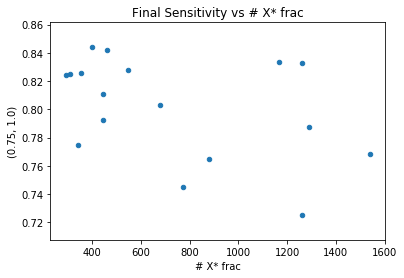

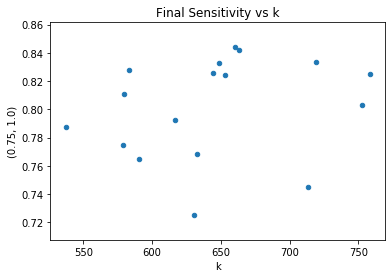

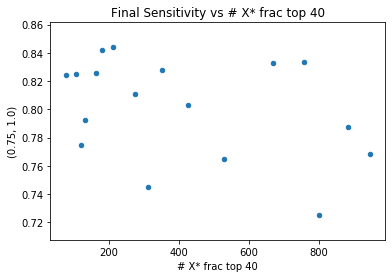

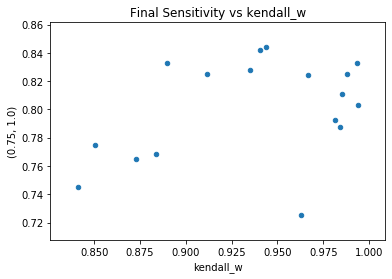

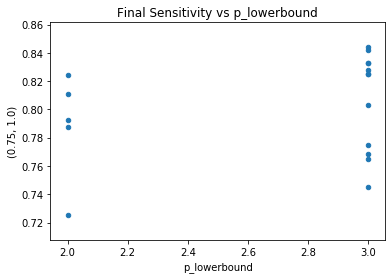

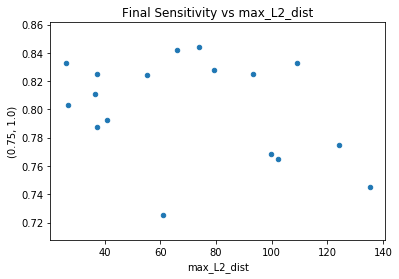

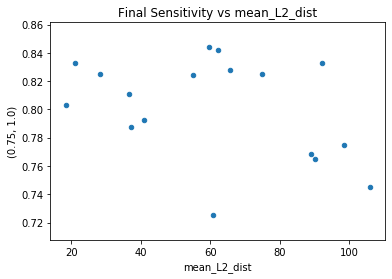

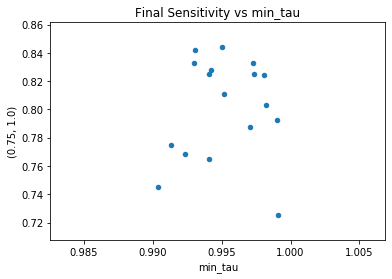

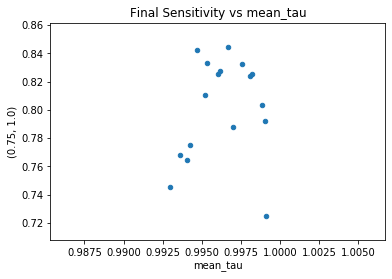

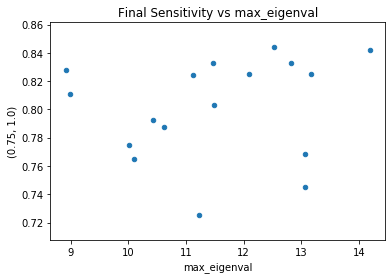

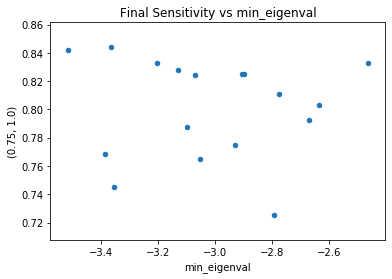

In [22]:
cdf = all_score_df.fillna(0.0).corr()
print(cdf.columns)
for col in all_score_df.columns:
    if col not in pairs:
        all_score_df.plot.scatter(col, pair_to_predict, title="Final Sensitivity vs " + col)
        print("Correlation between", pair_to_predict, "and", col, cdf[pair_to_predict].loc[col])

In [ ]:

import sklearn.linear_model as skl_lm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV

# List of all features to use to predict
# (drops the quantity to be predicted)
all_feature_cols = [c for c in all_score_df.columns if c not in pairs]

# Evaluates a regression model attempting to regress "pred_col" using leave-one-out
#     cross validation. If the model has parameters values to search over, each unique
#     parameter setting will be evaluated using 3-fold cross validation on top of the LOO CV.
# Reported statistics are [mean of absolute error] and [std of absolute error] over all LOO folds.
def evaluate(df,pred_col=pair_to_predict,feature_cols=all_feature_cols,model=DummyRegressor(),param_grid={}):
    loo = LeaveOneOut()
    y = df[pred_col]
    X = df[feature_cols]
    
    grid = GridSearchCV(model,param_grid,refit=True,verbose=0, cv=3,n_jobs=-1)
    scores = cross_val_score(grid, X, y, scoring="neg_mean_absolute_error", cv=loo, n_jobs=1)
    return pd.Series([len(scores),np.mean(np.abs(scores)),np.std(scores)],index=["Folds","MAE","STD"])

Same as above but with exhaustive feature selection

Below:
Seems to be a bug with feature subset selection. All scores come out the same.

In [23]:
import sklearn.linear_model as skl_lm
import random
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from itertools import chain, combinations


# List of all features to use to predict
# (drops the quantity to be predicted)
all_feature_cols = [c for c in all_score_df.columns if c not in pairs]

# Evaluates a regression model attempting to regress "pred_col" using leave-one-out
#     cross validation. If the model has parameters values to search over, each unique
#     parameter setting will be evaluated using 3-fold cross validation on top of the LOO CV.
# Reported statistics are [mean of absolute error] and [std of absolute error] over all LOO folds.
def evaluate(df,pred_col=pair_to_predict,feature_cols=all_feature_cols,model=DummyRegressor(),param_grid={}):
    exhaustive = {}
    loo = LeaveOneOut()
    y = df[pred_col]
    X = df[feature_cols]
    
    grid = GridSearchCV(model,param_grid,refit=True,verbose=0, cv=3,n_jobs=-1)
    
    # run on subsets of features
    exhaustive_feat_select = list(chain.from_iterable(combinations(list(range(len(X.columns))), r) for r in range(len(X.columns))))[1:]
    # only 10 feature subsets (out of 2^n) for debug purposes
    for ps in random.sample(exhaustive_feat_select, 10):
        print(ps)
        print(X.iloc[:, list(ps)])
        print(cross_val_score(grid, X.iloc[:, list(ps)], y, scoring="neg_mean_absolute_error", cv=loo, n_jobs=1))
        exhaustive[ps] = cross_val_score(grid, X.iloc[:, list(ps)], y, scoring="neg_mean_absolute_error", cv=loo, n_jobs=1)[:]
    
    # print(scores)
    return exhaustive

In [24]:
svr_model_results = evaluate(all_score_df,model=SVR(gamma='scale'),param_grid = {'C': [0.1,1,10,100], 'epsilon': [0.1,0.5,1],'kernel': ['linear', 'rbf']})
svr_model_results

(1, 2, 7, 8, 10)
               k # X* frac top 40   min_tau  mean_tau  min_eigenval
Year                                                               
2002  632.499984              947  0.992308  0.993590     -3.386522
2003  537.199999              885  0.997024  0.997024     -3.099875
2004  579.500001              275  0.995192  0.995192     -2.775487
2005  583.499826              351  0.994231  0.996154     -3.130967
2006  579.000001              119  0.991346  0.994231     -2.930973
2007  653.000000               76  0.998077  0.998077     -3.070766
2008  590.499855              529  0.994048  0.994048     -3.053487
2009  644.500000              162  0.994048  0.996032     -2.907447
2010  616.999999              130  0.999038  0.999038     -2.672556
2011  758.500003              106  0.997366  0.998244     -2.900806
2012  648.833288              668  0.997286  0.997588     -2.463962
2013  630.499931              801  0.999095  0.999095     -2.793281
2014  752.499851              4

/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

[-0.01635944 -0.00306974 -0.02594825 -0.04325595 -0.00962867 -0.03940979
 -0.01974772 -0.04076816 -0.00767902 -0.04065667 -0.04802624 -0.06980706
 -0.01870759 -0.04855834 -0.03923798 -0.06060943 -0.05763324]


/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

(0, 2, 4, 7, 9)
     # X* frac # X* frac top 40 p_lowerbound   min_tau  max_eigenval
Year                                                                
2002      1540              947            3  0.992308     13.066134
2003      1290              885            2  0.997024     10.621042
2004       444              275            2  0.995192      8.984207
2005       546              351            3  0.994231      8.920384
2006       344              119            3  0.991346     10.010710
2007       292               76            2  0.998077     11.124900
2008       878              529            3  0.994048     10.091479
2009       356              162            3  0.994048     12.085065
2010       446              130            2  0.999038     10.421649
2011       308              106            3  0.997366     13.172682
2012      1260              668            3  0.997286     11.473209
2013      1262              801            2  0.999095     11.227589
2014       678    

/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

[-0.01635944 -0.00306974 -0.02594825 -0.04325595 -0.00962867 -0.03940979
 -0.01974772 -0.04076816 -0.00767902 -0.04065667 -0.04802624 -0.06980706
 -0.01870759 -0.04855834 -0.03923798 -0.06060943 -0.05763324]


/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

(2, 4, 7)
     # X* frac top 40 p_lowerbound   min_tau
Year                                        
2002              947            3  0.992308
2003              885            2  0.997024
2004              275            2  0.995192
2005              351            3  0.994231
2006              119            3  0.991346
2007               76            2  0.998077
2008              529            3  0.994048
2009              162            3  0.994048
2010              130            2  0.999038
2011              106            3  0.997366
2012              668            3  0.997286
2013              801            2  0.999095
2014              426            3  0.998244
2015              759            3  0.992976
2016              311            3  0.990342
2017              212            3  0.995040
2018              179            3  0.993056


/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

[-0.01635944 -0.00306974 -0.02594825 -0.04325595 -0.00962867 -0.03940979
 -0.01974772 -0.04076816 -0.00767902 -0.04065667 -0.04802624 -0.06980706
 -0.01870759 -0.04855834 -0.03923798 -0.06060943 -0.05763324]


/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

(0, 2, 5, 7, 8, 9)
     # X* frac # X* frac top 40  max_L2_dist   min_tau  mean_tau  max_eigenval
Year                                                                          
2002      1540              947    99.749687  0.992308  0.993590     13.066134
2003      1290              885    37.229021  0.997024  0.997024     10.621042
2004       444              275    36.633318  0.995192  0.995192      8.984207
2005       546              351    79.410327  0.994231  0.996154      8.920384
2006       344              119   124.306074  0.991346  0.994231     10.010710
2007       292               76    55.154329  0.998077  0.998077     11.124900
2008       878              529   102.469508  0.994048  0.994048     10.091479
2009       356              162    93.209442  0.994048  0.996032     12.085065
2010       446              130    41.012193  0.999038  0.999038     10.421649
2011       308              106    37.389838  0.997366  0.998244     13.172682
2012      1260              668  

/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

[-0.01635944 -0.00306974 -0.02594825 -0.04325595 -0.00962867 -0.03940979
 -0.01974772 -0.04076816 -0.00767902 -0.04065667 -0.04802624 -0.06980706
 -0.01870759 -0.04855834 -0.03923798 -0.06060943 -0.05763324]


/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

(0, 1, 3, 4, 7, 8)
     # X* frac           k  kendall_w p_lowerbound   min_tau  mean_tau
Year                                                                  
2002      1540  632.499984   0.883741            3  0.992308  0.993590
2003      1290  537.199999   0.984135            2  0.997024  0.997024
2004       444  579.500001   0.985337            2  0.995192  0.995192
2005       546  583.499826   0.935315            3  0.994231  0.996154
2006       344  579.000001   0.850476            3  0.991346  0.994231
2007       292  653.000000   0.966761            2  0.998077  0.998077
2008       878  590.499855   0.872812            3  0.994048  0.994048
2009       356  644.500000   0.911600            3  0.994048  0.996032
2010       446  616.999999   0.981622            2  0.999038  0.999038
2011       308  758.500003   0.988141            3  0.997366  0.998244
2012      1260  648.833288   0.993562            3  0.997286  0.997588
2013      1262  630.499931   0.963106            2  0.9990

/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

[-0.01635944 -0.00306974 -0.02594825 -0.04325595 -0.00962867 -0.03940979
 -0.01974772 -0.04076816 -0.00767902 -0.04065667 -0.04802624 -0.06980706
 -0.01870759 -0.04855834 -0.03923798 -0.06060943 -0.05763324]


/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

(0, 3, 4, 6, 9, 10)
     # X* frac  kendall_w p_lowerbound  mean_L2_dist  max_eigenval  \
Year                                                                 
2002      1540   0.883741            3     88.929667     13.066134   
2003      1290   0.984135            2     37.229021     10.621042   
2004       444   0.985337            2     36.633318      8.984207   
2005       546   0.935315            3     65.632273      8.920384   
2006       344   0.850476            3     98.344496     10.010710   
2007       292   0.966761            2     55.154329     11.124900   
2008       878   0.872812            3     89.982904     10.091479   
2009       356   0.911600            3     74.813184     12.085065   
2010       446   0.981622            2     41.012193     10.421649   
2011       308   0.988141            3     28.303567     13.172682   
2012      1260   0.993562            3     21.075151     11.473209   
2013      1262   0.963106            2     60.811183     11.227589   


/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

[-0.01635944 -0.00306974 -0.02594825 -0.04325595 -0.00962867 -0.03940979
 -0.01974772 -0.04076816 -0.00767902 -0.04065667 -0.04802624 -0.06980706
 -0.01870759 -0.04855834 -0.03923798 -0.06060943 -0.05763324]


/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

(0, 1, 4, 5, 7)
     # X* frac           k p_lowerbound  max_L2_dist   min_tau
Year                                                          
2002      1540  632.499984            3    99.749687  0.992308
2003      1290  537.199999            2    37.229021  0.997024
2004       444  579.500001            2    36.633318  0.995192
2005       546  583.499826            3    79.410327  0.994231
2006       344  579.000001            3   124.306074  0.991346
2007       292  653.000000            2    55.154329  0.998077
2008       878  590.499855            3   102.469508  0.994048
2009       356  644.500000            3    93.209442  0.994048
2010       446  616.999999            2    41.012193  0.999038
2011       308  758.500003            3    37.389838  0.997366
2012      1260  648.833288            3    26.000000  0.997286
2013      1262  630.499931            2    60.811183  0.999095
2014       678  752.499851            3    26.907248  0.998244
2015      1166  718.999992            3

/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

[-0.01635944 -0.00306974 -0.02594825 -0.04325595 -0.00962867 -0.03940979
 -0.01974772 -0.04076816 -0.00767902 -0.04065667 -0.04802624 -0.06980706
 -0.01870759 -0.04855834 -0.03923798 -0.06060943 -0.05763324]


/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

(3, 4, 5, 6, 7, 10)
      kendall_w p_lowerbound  max_L2_dist  mean_L2_dist   min_tau  \
Year                                                                
2002   0.883741            3    99.749687     88.929667  0.992308   
2003   0.984135            2    37.229021     37.229021  0.997024   
2004   0.985337            2    36.633318     36.633318  0.995192   
2005   0.935315            3    79.410327     65.632273  0.994231   
2006   0.850476            3   124.306074     98.344496  0.991346   
2007   0.966761            2    55.154329     55.154329  0.998077   
2008   0.872812            3   102.469508     89.982904  0.994048   
2009   0.911600            3    93.209442     74.813184  0.994048   
2010   0.981622            2    41.012193     41.012193  0.999038   
2011   0.988141            3    37.389838     28.303567  0.997366   
2012   0.993562            3    26.000000     21.075151  0.997286   
2013   0.963106            2    60.811183     60.811183  0.999095   
2014   0.99385

/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

[-0.01635944 -0.00306974 -0.02594825 -0.04325595 -0.00962867 -0.03940979
 -0.01974772 -0.04076816 -0.00767902 -0.04065667 -0.04802624 -0.06980706
 -0.01870759 -0.04855834 -0.03923798 -0.06060943 -0.05763324]


/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

(6, 8, 10)
      mean_L2_dist  mean_tau  min_eigenval
Year                                      
2002     88.929667  0.993590     -3.386522
2003     37.229021  0.997024     -3.099875
2004     36.633318  0.995192     -2.775487
2005     65.632273  0.996154     -3.130967
2006     98.344496  0.994231     -2.930973
2007     55.154329  0.998077     -3.070766
2008     89.982904  0.994048     -3.053487
2009     74.813184  0.996032     -2.907447
2010     41.012193  0.999038     -2.672556
2011     28.303567  0.998244     -2.900806
2012     21.075151  0.997588     -2.463962
2013     60.811183  0.999095     -2.793281
2014     18.397173  0.998829     -2.635482
2015     92.171495  0.995318     -3.203551
2016    105.920859  0.992976     -3.355600
2017     59.612681  0.996693     -3.364588
2018     62.342968  0.994709     -3.517742


/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

[-0.01635944 -0.00306974 -0.02594825 -0.04325595 -0.00962867 -0.03940979
 -0.01974772 -0.04076816 -0.00767902 -0.04065667 -0.04802624 -0.06980706
 -0.01870759 -0.04855834 -0.03923798 -0.06060943 -0.05763324]


/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

(2, 3, 4, 5, 7, 8, 9)
     # X* frac top 40  kendall_w p_lowerbound  max_L2_dist   min_tau  \
Year                                                                   
2002              947   0.883741            3    99.749687  0.992308   
2003              885   0.984135            2    37.229021  0.997024   
2004              275   0.985337            2    36.633318  0.995192   
2005              351   0.935315            3    79.410327  0.994231   
2006              119   0.850476            3   124.306074  0.991346   
2007               76   0.966761            2    55.154329  0.998077   
2008              529   0.872812            3   102.469508  0.994048   
2009              162   0.911600            3    93.209442  0.994048   
2010              130   0.981622            2    41.012193  0.999038   
2011              106   0.988141            3    37.389838  0.997366   
2012              668   0.993562            3    26.000000  0.997286   
2013              801   0.963106          

/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

[-0.01635944 -0.00306974 -0.02594825 -0.04325595 -0.00962867 -0.03940979
 -0.01974772 -0.04076816 -0.00767902 -0.04065667 -0.04802624 -0.06980706
 -0.01870759 -0.04855834 -0.03923798 -0.06060943 -0.05763324]


/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default

{(1,
  2,
  7,
  8,
  10): array([-0.01635944, -0.00306974, -0.02594825, -0.04325595, -0.00962867,
        -0.03940979, -0.01974772, -0.04076816, -0.00767902, -0.04065667,
        -0.04802624, -0.06980706, -0.01870759, -0.04855834, -0.03923798,
        -0.06060943, -0.05763324]),
 (0,
  2,
  4,
  7,
  9): array([-0.01635944, -0.00306974, -0.02594825, -0.04325595, -0.00962867,
        -0.03940979, -0.01974772, -0.04076816, -0.00767902, -0.04065667,
        -0.04802624, -0.06980706, -0.01870759, -0.04855834, -0.03923798,
        -0.06060943, -0.05763324]),
 (2,
  4,
  7): array([-0.01635944, -0.00306974, -0.02594825, -0.04325595, -0.00962867,
        -0.03940979, -0.01974772, -0.04076816, -0.00767902, -0.04065667,
        -0.04802624, -0.06980706, -0.01870759, -0.04855834, -0.03923798,
        -0.06060943, -0.05763324]),
 (0,
  2,
  5,
  7,
  8,
  9): array([-0.01635944, -0.00306974, -0.02594825, -0.04325595, -0.00962867,
        -0.03940979, -0.01974772, -0.04076816, -0.00767902, -0.040

In [26]:
svr_model_results

{(1,
  2,
  7,
  8,
  10): array([-0.01635944, -0.00306974, -0.02594825, -0.04325595, -0.00962867,
        -0.03940979, -0.01974772, -0.04076816, -0.00767902, -0.04065667,
        -0.04802624, -0.06980706, -0.01870759, -0.04855834, -0.03923798,
        -0.06060943, -0.05763324]),
 (0,
  2,
  4,
  7,
  9): array([-0.01635944, -0.00306974, -0.02594825, -0.04325595, -0.00962867,
        -0.03940979, -0.01974772, -0.04076816, -0.00767902, -0.04065667,
        -0.04802624, -0.06980706, -0.01870759, -0.04855834, -0.03923798,
        -0.06060943, -0.05763324]),
 (2,
  4,
  7): array([-0.01635944, -0.00306974, -0.02594825, -0.04325595, -0.00962867,
        -0.03940979, -0.01974772, -0.04076816, -0.00767902, -0.04065667,
        -0.04802624, -0.06980706, -0.01870759, -0.04855834, -0.03923798,
        -0.06060943, -0.05763324]),
 (0,
  2,
  5,
  7,
  8,
  9): array([-0.01635944, -0.00306974, -0.02594825, -0.04325595, -0.00962867,
        -0.03940979, -0.01974772, -0.04076816, -0.00767902, -0.040

In [ ]:
print(sorted(list(np.apply_along_axis(np.mean, 1, x))))

In [ ]:
lr_model_results = evaluate(all_score_df,model=LinearRegression(),param_grid = {'fit_intercept': [True, False]})
lr_model_results


In [ ]:
dummy_model_results = evaluate(all_score_df)
dummy_model_results

In [ ]:
x = ['Baseline', 'SVR', "Linear Regression"]
maes = [dummy_model_results["MAE"], svr_model_results["MAE"], lr_model_results["MAE"]]
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, maes)
plt.xlabel("Model")
plt.ylabel("Error")
plt.title("Mean Absolute Error of Regression Models")

plt.xticks(x_pos, x)

plt.show()